In [ ]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 9.9 MB/s 
     |████████████████████████████████| 3.3 MB 53.9 MB/s 
     |████████████████████████████████| 26.3 MB 1.4 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
!pip install -U 'fsspec>=0.3.3'

     |████████████████████████████████| 132 kB 7.0 MB/s 


In [ ]:
import art.utils
import numpy as np
from art.defences.preprocessor import FeatureSqueezing, JpegCompression, SpatialSmoothing

import tracemalloc
import pandas as pd
import dask.dataframe as dd
import time
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt


import os
from art.estimators.classification import KerasClassifier
import art.utils
import  sklearn.metrics
import sklearn
from art.attacks.extraction import *
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, DeepFool, CarliniL2Method,BrendelBethgeAttack
from art.attacks.evasion import BoundaryAttack
tf.compat.v1.disable_eager_execution()
%matplotlib inline 


In [ ]:
def tracing_start():
    tracemalloc.stop()
    print("nTracing Status : ", tracemalloc.is_tracing())
    tracemalloc.start()
    print("Tracing Status : ", tracemalloc.is_tracing())
def tracing_mem():
    first_size, first_peak = tracemalloc.get_traced_memory()
    peak = first_peak/(1024*1024)
    print("Peak Size in MB - ", peak)

In [ ]:
(x_train, y_train), (x_test, y_test), min_, max_ = art.utils.load_dataset(str("cifar10")) 

print("x_train shape: " + str(x_train.shape) + "\n" + "x_train size: " + str(x_train.size))

print("y_train shape: " + str(y_train.shape) + "\n" + "x_train size: " + str(y_train.size))

print("x_test shape: " + str(x_test.shape) + "\n" + "x_train size: " + str(x_test.size))

print("y_test shape: " + str(y_test.shape) + "\n" + "x_train size: " + str(y_test.size))

x_train shape: (50000, 32, 32, 3)
x_train size: 153600000
y_train shape: (50000, 10)
x_train size: 500000
x_test shape: (10000, 32, 32, 3)
x_train size: 30720000
y_test shape: (10000, 10)
x_train size: 100000


In [ ]:
# make a subset of test data
idx = np.arange(len(x_test))
subset_x_test = []
subset_y_test = []
y_label = np.where(y_test > 0)[1]
for i in range(10):
    mask = y_label == i
    subset_y_test.append(y_test[mask][10:20])
    subset_x_test.append(x_test[mask][10:20])

subset_x_test = np.concatenate(subset_x_test,axis=0)
subset_y_test = np.concatenate(subset_y_test,axis=0)

In [ ]:
#from collections import Counter
#print(Counter(list(subset_y_test)))
type(subset_y_test)
subset_y_test.shape

(100, 10)

Subset of Original Test Images


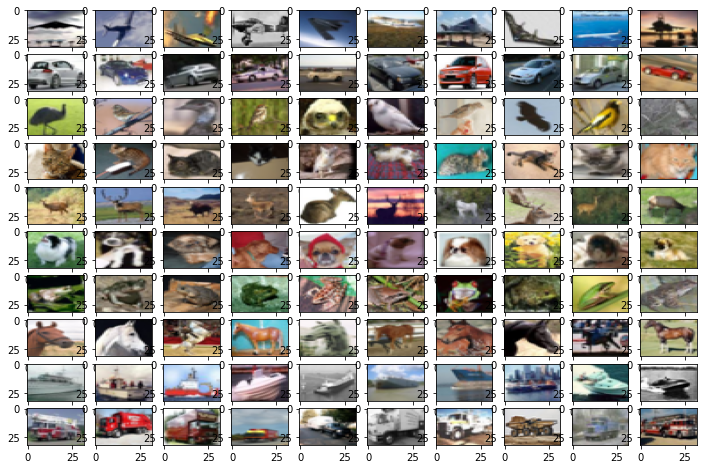

In [ ]:
# visualize data by plotting images
print("Subset of Original Test Images")
fig, ax = plt.subplots(10, 10, figsize=(12,8))
k = 0
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(subset_x_test[k], aspect='auto')
        k += 1
plt.show()

In [ ]:
model_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.KerasLayer(model_url, input_shape=(32, 32, 3))
victim_model = tf.keras.Sequential([
        model,
        tf.keras.layers.Activation('softmax')
])

victim_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
victim_model.summary()
victim_classifier = KerasClassifier(model=victim_model, clip_values=(0., 1.))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 10)                7796426   
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
predictions = victim_classifier.predict(x_test) 
dependent_maxvalue = np.argmax(y_test, axis=1)
predict_maxvalue = np.argmax(predictions, axis=1)

# calculates the accuracy of the predictions
begin_example_accuracy = np.sum(predict_maxvalue == dependent_maxvalue) / len(y_test) 
acc_rate = begin_example_accuracy * 100

print("Accuracy for classifier on original test set: {}%\n".format(acc_rate))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy for classifier on original test set: 94.52000000000001%



In [ ]:
# accuracy on original subset of test set

predictions = victim_classifier.predict(subset_x_test) 
dependent_maxvalue = np.argmax(subset_y_test, axis=1)
predict_maxvalue = np.argmax(predictions, axis=1)

# calculates the accuracy of the predictions
begin_example_accuracy = np.sum(predict_maxvalue == dependent_maxvalue) / len(subset_y_test) 
acc_rate = begin_example_accuracy * 100

print("Accuracy for classifier on original subset of test set: {}%\n".format(acc_rate))

Accuracy for classifier on original subset of test set: 97.0%



# FeatureSqueezing

In [ ]:
preproc = FeatureSqueezing(clip_values=(0, 1), bit_depth=2)
x_squeezed, _ = preproc(subset_x_test)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(
    victim_classifier.predict(x_squeezed), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after FeatureSqueezing: %.2f%%" % (acc * 100))


 Accuracy of classifier on Original Subset after FeatureSqueezing: 50.00%


FGSM ATTACK

In [ ]:
import time
# FGSM attack on subset of test set
# Craft adversarial samples with FGSM
epsilon = 0.1  # Maximum perturbation
adv_crafter_fgsm = FastGradientMethod(victim_classifier, eps=epsilon)

start = time.time()
x_sub_test_adv_fgsm = adv_crafter_fgsm.generate(x=subset_x_test)
end = time.time()
print ("Time elapsed in seconds to generate FGSM adversarial inputs:", end - start)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_sub_test_adv_fgsm), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on subset of test set for FGSM attack: %.2f%%" % (acc * 100))

Time elapsed in seconds to generate FGSM adversarial inputs: 1.5015537738800049

 Accuracy of classifier on subset of test set for FGSM attack: 14.00%


In [ ]:
tracing_start()
start = time.time()

preproc = FeatureSqueezing(clip_values=(0, 1), bit_depth=2)
x_squeezed_fgsm, _ = preproc(x_sub_test_adv_fgsm)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_squeezed_fgsm), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on FGSM Perturbed Subset after FeatureSqueezing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 4.778861999511719 milli seconds
Peak Size in MB -  3.5491981506347656

 Accuracy of classifier on FGSM Perturbed Subset after FeatureSqueezing: 12.00%


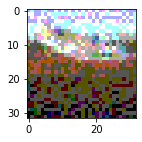

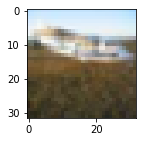

In [ ]:
x_squeezed_fgsm.shape
plt.figure(figsize = (2,2))
plt.imshow(x_squeezed_fgsm[5])

plt.figure(figsize = (2,2))
plt.imshow(subset_x_test[5])

DeepFool

In [ ]:
adv_crafter_deepfool = DeepFool(victim_classifier, max_iter=100, verbose=False)

start = time.time()
x_sub_test_adv_deepfool = adv_crafter_deepfool.generate(x=subset_x_test)
end = time.time()
print ("Time elapsed in seconds to generate deepfool adversarial inputs:", end - start)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_sub_test_adv_deepfool), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for DeepFool Attack: %.2f%%" % (acc * 100))

Time elapsed in seconds to generate deepfool adversarial inputs: 21.73545479774475

 Accuracy of Classifier on Subset of Test Images for DeepFool Attack: 6.00%


In [ ]:
tracing_start()
start = time.time()

preproc = FeatureSqueezing(clip_values=(0, 1), bit_depth=2)
x_squeezed_deepfool, _ = preproc(x_sub_test_adv_deepfool)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_squeezed_deepfool), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on DeepFool Perturbed Subset after FeatureSqueezing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 6.305456161499023 milli seconds
Peak Size in MB -  3.553478240966797

 Accuracy of classifier on DeepFool Perturbed Subset after FeatureSqueezing: 15.00%


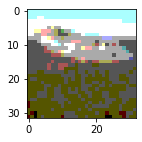

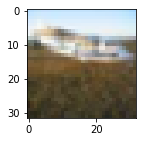

In [ ]:
x_squeezed_deepfool.shape
plt.figure(figsize = (2,2))
plt.imshow(x_squeezed_deepfool[5])

plt.figure(figsize = (2,2))
plt.imshow(subset_x_test[5])

Carlini

In [ ]:
# Carlini attack on subset of test set

adv_crafter_carlini = CarliniL2Method(victim_classifier, max_iter=1, verbose=False)
start = time.time()
x_sub_test_adv_carlini = adv_crafter_carlini.generate(x=subset_x_test)
end = time.time()
print ("Time elapsed in seconds to generate carliniL2method adversarial inputs:", end - start)


# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_sub_test_adv_carlini), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for CarliniL2Method Attack: %.2f%%" % (acc * 100))

Time elapsed in seconds to generate carliniL2method adversarial inputs: 65.66892886161804

 Accuracy of Classifier on Subset of Test Images for CarliniL2Method Attack: 79.00%


In [ ]:
tracing_start()
start = time.time()

preproc = FeatureSqueezing(clip_values=(0, 1), bit_depth=2)
x_squeezed_carlini, _ = preproc(x_sub_test_adv_carlini)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_squeezed_carlini), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Carlini Perturbed Subset after FeatureSqueezing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 5.348920822143555 milli seconds
Peak Size in MB -  3.549663543701172

 Accuracy of classifier on Carlini Perturbed Subset after FeatureSqueezing: 50.00%


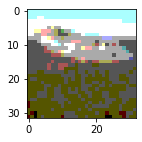

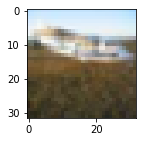

In [ ]:
x_squeezed_carlini.shape
plt.figure(figsize = (2,2))
plt.imshow(x_squeezed_carlini[5])

plt.figure(figsize = (2,2))
plt.imshow(subset_x_test[5])

# GaussianAugmentation


In [ ]:
from art.defences.preprocessor import GaussianAugmentation

In [ ]:
ga = GaussianAugmentation(augmentation=False, ratio=1, sigma=.02)
x_ga, _ = ga(subset_x_test)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(
    victim_classifier.predict(x_ga), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after GaussianAugmentation: %.2f%%" % (acc * 100))


 Accuracy of classifier on Original Subset after GaussianAugmentation: 93.00%


In [ ]:
tracing_start()
start = time.time()

x_ga_fgsm, _ = ga(x_sub_test_adv_fgsm)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_ga_fgsm), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on FGSM Perturbed Subset after FeatureSqueezing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 19.947052001953125 milli seconds
Peak Size in MB -  4.702065467834473

 Accuracy of classifier on FGSM Perturbed Subset after FeatureSqueezing: 12.00%


SaliencyMapMethod



In [ ]:
from art.attacks.evasion.saliency_map import SaliencyMapMethod
df = SaliencyMapMethod(victim_classifier, theta=1, batch_size=100, verbose=False)
start = time.time()
x_test_adv_SaliencyMapMethod = df.generate(subset_x_test, subset_y_test)
end = time.time()
print ("Time elapsed in seconds to generate x_test_adv_ThresholdAttack adversarial inputs:", end - start)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_test_adv_SaliencyMapMethod), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for x_test_adv_ThresholdAttack Attack: %.2f%%" % (acc * 100))

Time elapsed in seconds to generate x_test_adv_ThresholdAttack adversarial inputs: 0.8155512809753418

 Accuracy of Classifier on Subset of Test Images for x_test_adv_ThresholdAttack Attack: 100.00%


In [ ]:
tracing_start()
start = time.time()

x_ga_saliencymapmet, _ = ga(x_test_adv_SaliencyMapMethod)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_ga_saliencymapmet), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on SaliencyMapMethod Perturbed Subset after FeatureSqueezing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 18.51797103881836 milli seconds
Peak Size in MB -  4.704035758972168

 Accuracy of classifier on SaliencyMapMethod Perturbed Subset after FeatureSqueezing: 92.00%


virtual Adversarial attack

In [ ]:
from art.attacks.evasion.virtual_adversarial import VirtualAdversarialMethod
df = VirtualAdversarialMethod(victim_classifier, batch_size=100, max_iter=2, verbose=False)
start = time.time()
x_test_adv_VirtualAdversarialMethod = df.generate(subset_x_test)

end = time.time()
print ("Time elapsed in seconds to generate SimBA adversarial inputs:", end - start)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_test_adv_VirtualAdversarialMethod), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for SimBA Attack: %.2f%%" % (acc * 100))

Time elapsed in seconds to generate SimBA adversarial inputs: 79.15269207954407

 Accuracy of Classifier on Subset of Test Images for SimBA Attack: 96.00%


In [ ]:
tracing_start()
start = time.time()

x_ga_virtualadv, _ = ga(x_test_adv_VirtualAdversarialMethod)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_ga_virtualadv), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on VirtualAdversarial Perturbed Subset after FeatureSqueezing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 21.286964416503906 milli seconds
Peak Size in MB -  4.774151802062988

 Accuracy of classifier on VirtualAdversarial Perturbed Subset after FeatureSqueezing: 90.00%


#JpegCompression

In [ ]:
from art.defences.preprocessor import JpegCompression
jpeg_compression = JpegCompression(clip_values=(0, 255))

x_jpegCom, _ = jpeg_compression(subset_x_test)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(
    victim_classifier.predict(x_ga), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after JpegCompression: %.2f%%" % (acc * 100))


 Accuracy of classifier on Original Subset after JpegCompression: 93.00%


In [ ]:
tracing_start()
start = time.time()

x_jpegCom_fgsm, _ = jpeg_compression(x_sub_test_adv_fgsm)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_jpegCom_fgsm), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on FGSM Perturbed Subset after JpegCompression: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 43.61367225646973 milli seconds
Peak Size in MB -  1.7660160064697266

 Accuracy of classifier on FGSM Perturbed Subset after JpegCompression: 10.00%


# LabelSmoothing

In [ ]:
from art.defences.preprocessor import LabelSmoothing
ls = LabelSmoothing(max_value=0.1)
_, y_smooth = ls(None, subset_y_test)
y_smooth = np.argmax(y_smooth, axis=1)

acc = np.sum(y_smooth == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after LabelSmoothing: %.2f%%" % (acc * 100))


 Accuracy of classifier on Original Subset after LabelSmoothing: 10.00%


In [ ]:
preds = (victim_classifier.predict(x_sub_test_adv_fgsm))

tracing_start()
start = time.time()

_, y_smooth_fgsm = ls(None, preds)
y_smooth_fgsm = np.argmax(y_smooth_fgsm, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(y_smooth_fgsm == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after LabelSmoothing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 0.7452964782714844 milli seconds
Peak Size in MB -  0.016599655151367188

 Accuracy of classifier on Original Subset after LabelSmoothing: 14.00%


In [ ]:
preds = (victim_classifier.predict(x_test_adv_SaliencyMapMethod))

tracing_start()
start = time.time()

_, y_smooth_salincy = ls(None, preds)
y_smooth_salincy = np.argmax(y_smooth_salincy, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(y_smooth_salincy == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after LabelSmoothing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 0.1881122589111328 milli seconds
Peak Size in MB -  0.015006065368652344

 Accuracy of classifier on Original Subset after LabelSmoothing: 100.00%


In [ ]:
preds = (victim_classifier.predict(x_test_adv_VirtualAdversarialMethod))

tracing_start()
start = time.time()

_, y_smooth_salincy = ls(None, preds)
y_smooth_salincy = np.argmax(y_smooth_salincy, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(y_smooth_salincy == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after LabelSmoothing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 0.21505355834960938 milli seconds
Peak Size in MB -  0.015006065368652344

 Accuracy of classifier on Original Subset after LabelSmoothing: 96.00%


# SpatialSmoothing

In [ ]:
from art.defences.preprocessor import SpatialSmoothing
spatial_smoothing = SpatialSmoothing(channels_first=True, window_size=2)
x_defended, _ = spatial_smoothing(subset_x_test)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(
    victim_classifier.predict(x_defended), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after SpatialSmoothing: %.2f%%" % (acc * 100))


 Accuracy of classifier on Original Subset after SpatialSmoothing: 87.00%


In [ ]:
tracing_start()
start = time.time()

x_spatial_smoothing_fgsm, _ = spatial_smoothing(x_sub_test_adv_fgsm)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_spatial_smoothing_fgsm), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on FGSM Perturbed Subset after SpatialSmoothing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 14.216899871826172 milli seconds
Peak Size in MB -  1.1883840560913086

 Accuracy of classifier on FGSM Perturbed Subset after SpatialSmoothing: 11.00%


In [ ]:
tracing_start()
start = time.time()

x_spatial_smoothing_deepfool, _ = spatial_smoothing(x_sub_test_adv_deepfool)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_spatial_smoothing_deepfool), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on DeepFool Perturbed Subset after SpatialSmoothing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 14.567136764526367 milli seconds
Peak Size in MB -  1.1844425201416016

 Accuracy of classifier on DeepFool Perturbed Subset after SpatialSmoothing: 14.00%


In [ ]:
from art.attacks.evasion import BasicIterativeMethod
attack_BasicIterativeMethod = BasicIterativeMethod(victim_classifier)
start = time.time()
x_train_adv_BasicIterativeMethod = attack_BasicIterativeMethod.generate(subset_x_test)
end = time.time()
print ("Time elapsed in seconds to generate frameSaliency adversarial inputs:", end - start)


# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_train_adv_BasicIterativeMethod), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for BasicIterativeMethod Attack: %.2f%%" % (acc * 100))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Time elapsed in seconds to generate frameSaliency adversarial inputs: 7.894814729690552

 Accuracy of Classifier on Subset of Test Images for BasicIterativeMethod Attack: 1.00%


In [ ]:
tracing_start()
start = time.time()

x_spatial_smoothing_bim, _ = spatial_smoothing(x_train_adv_BasicIterativeMethod)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_spatial_smoothing_bim), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on BasicIterativeMethod Perturbed Subset after SpatialSmoothing: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 15.386104583740234 milli seconds
Peak Size in MB -  1.1835613250732422

 Accuracy of classifier on BasicIterativeMethod Perturbed Subset after SpatialSmoothing: 4.00%


# TotalVarMin

In [ ]:
from art.defences.preprocessor import TotalVarMin
preprocess = TotalVarMin(clip_values=(0, 1))
x_preprocessed, _ = preprocess(subset_x_test)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(
    victim_classifier.predict(x_preprocessed), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after TotalVarMin: %.2f%%" % (acc * 100))


 Accuracy of classifier on Original Subset after TotalVarMin: 25.00%


In [ ]:
from art.attacks.evasion.zoo import ZooAttack
zoo = ZooAttack(classifier=victim_classifier, max_iter=1, binary_search_steps=1, learning_rate=0.1, verbose=False)
start = time.time()
x_test_mnist_adv_ZooAttack = zoo.generate(subset_x_test)

end = time.time()
print ("Time elapsed in seconds to generate SimBA adversarial inputs:", end - start)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_test_mnist_adv_ZooAttack), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for SimBA Attack: %.2f%%" % (acc * 100))


Time elapsed in seconds to generate SimBA adversarial inputs: 327.95277070999146

 Accuracy of Classifier on Subset of Test Images for SimBA Attack: 86.00%


In [ ]:
tracing_start()
start = time.time()

x_spatial_smoothing_zooattack, _ = preprocess(x_test_mnist_adv_ZooAttack)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_spatial_smoothing_zooattack), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Zoo Attack Perturbed Subset after TotalVarMin: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 2109.018087387085 milli seconds
Peak Size in MB -  3.610226631164551

 Accuracy of classifier on Zoo Attack Perturbed Subset after TotalVarMin: 27.00%


In [ ]:
from art.attacks.evasion import SquareAttack
attack = SquareAttack(
            estimator=victim_classifier, norm=2, max_iter=5, eps=0.3, p_init=0.8, nb_restarts=1, verbose=False
        )
start = time.time()
x_train_mnist_adv_SquareAttack = attack.generate(x=subset_x_test, y=subset_y_test)
end = time.time()
print ("Time elapsed in seconds to generate SimBA adversarial inputs:", end - start)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_train_mnist_adv_SquareAttack), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for SimBA Attack: %.2f%%" % (acc * 100))

Time elapsed in seconds to generate SimBA adversarial inputs: 0.5310506820678711

 Accuracy of Classifier on Subset of Test Images for SimBA Attack: 96.00%


In [ ]:
tracing_start()
start = time.time()

x_spatial_smoothing_squareattack, _ = preprocess(x_train_mnist_adv_SquareAttack)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_spatial_smoothing_squareattack), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on square Attack Perturbed Subset after TotalVarMin: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 2075.5624771118164 milli seconds
Peak Size in MB -  2.4634599685668945

 Accuracy of classifier on square Attack Perturbed Subset after TotalVarMin: 25.00%


In [ ]:
from art.attacks.evasion.spatial_transformation import SpatialTransformation
attack_st = SpatialTransformation(
            victim_classifier, max_translation=10.0, num_translations=3, max_rotation=30.0, 
            num_rotations=3, verbose=False
        )
start = time.time()
x_train_adv_SpatialTransformation = attack_st.generate(subset_x_test)

end = time.time()
print ("Time elapsed in seconds to generate SimBA adversarial inputs:", end - start)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_train_adv_SpatialTransformation), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for SimBA Attack: %.2f%%" % (acc * 100))

Time elapsed in seconds to generate SimBA adversarial inputs: 33.918872594833374

 Accuracy of Classifier on Subset of Test Images for SimBA Attack: 48.00%


In [ ]:
tracing_start()
start = time.time()

x_spatial_smoothing_SpatialTransformation, _ = preprocess(x_train_adv_SpatialTransformation)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_spatial_smoothing_SpatialTransformation), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on spatial transformation Attack Perturbed Subset after TotalVarMin: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 2194.0019130706787 milli seconds
Peak Size in MB -  3.570631980895996

 Accuracy of classifier on spatial transformation Attack Perturbed Subset after TotalVarMin: 15.00%


# Postprocessor

#ClassLabels

In [ ]:
from art.defences.postprocessor import ClassLabels

In [ ]:
postprocessor = ClassLabels()
post_preds = postprocessor(preds=subset_y_test)
post_preds = np.argmax(post_preds, axis=1)

acc = np.sum(post_preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after classlabel: %.2f%%" % (acc * 100))


 Accuracy of classifier on Original Subset after classlabel: 10.00%


In [ ]:
from art.attacks.evasion import ElasticNet
ead = ElasticNet(classifier=victim_classifier, targeted=True, max_iter=1)

start = time.time()
x_test_adv_ead = ead.generate(x=subset_x_test,  y=subset_y_test)
end = time.time()
print ("Time elapsed in seconds to generate elasticNet adversarial inputs:", end - start)
# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_test_adv_ead), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for ElasticNet Attack: %.2f%%" % (acc * 100))

EAD:   0%|          | 0/100 [00:00<?, ?it/s]

Time elapsed in seconds to generate elasticNet adversarial inputs: 27.652907848358154

 Accuracy of Classifier on Subset of Test Images for ElasticNet Attack: 99.00%


In [ ]:
#ElasticNet
preds = (victim_classifier.predict(x_test_adv_ead))

tracing_start()
start = time.time()

post_preds = postprocessor(preds=preds)
post_preds = np.argmax(post_preds, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Elastic Net after classlabel: %.2f%%" % (acc * 100))


nTracing Status :  False
Tracing Status :  True
time elapsed 1.9850730895996094 milli seconds
Peak Size in MB -  0.014669418334960938

 Accuracy of classifier on Elastic Net after classlabel: 10.00%


In [ ]:
preds_fgsm = (victim_classifier.predict(x_sub_test_adv_fgsm))

tracing_start()
start = time.time()

post_preds_fgsm = postprocessor(preds=preds_fgsm)
post_preds_fgsm = np.argmax(post_preds_fgsm, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_fgsm == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on FGSM after classlabel: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 2.03704833984375 milli seconds
Peak Size in MB -  0.014768600463867188

 Accuracy of classifier on FGSM after classlabel: 10.00%


In [ ]:
preds_spatialtrnsf = (victim_classifier.predict(x_train_adv_SpatialTransformation))

tracing_start()
start = time.time()

post_preds_spatialtrnsf = postprocessor(preds=preds_spatialtrnsf)
post_preds_spatialtrnsf = np.argmax(post_preds_spatialtrnsf, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_spatialtrnsf == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on spatial transformation  after classlabel: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 2.424001693725586 milli seconds
Peak Size in MB -  0.01986980438232422

 Accuracy of classifier on spatial transformation  after classlabel: 10.00%


#HighConfidence

In [ ]:
from art.defences.postprocessor import HighConfidence

In [ ]:
postprocessor = HighConfidence(cutoff=0.1)
post_preds = postprocessor(preds=subset_y_test)

post_preds = np.argmax(post_preds, axis=1)

acc = np.sum(post_preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after highconfidence: %.2f%%" % (acc * 100))


 Accuracy of classifier on Original Subset after highconfidence: 100.00%


In [ ]:
preds_fgsm = (victim_classifier.predict(x_sub_test_adv_fgsm))

tracing_start()
start = time.time()

post_preds_fgsm = postprocessor(preds=preds_fgsm)
post_preds_fgsm = np.argmax(post_preds_fgsm, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_fgsm == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on FGSM after highconfidence: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 0.9720325469970703 milli seconds
Peak Size in MB -  0.01951885223388672

 Accuracy of classifier on FGSM after highconfidence: 14.00%


In [ ]:
preds_deepfool = (victim_classifier.predict(x_sub_test_adv_deepfool))

tracing_start()
start = time.time()

post_preds_deepfool = postprocessor(preds=preds_deepfool)
post_preds_deepfool = np.argmax(post_preds_deepfool, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_deepfool == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on deepfool after highconfidence: %.2f%%" % (acc * 100))


nTracing Status :  False
Tracing Status :  True
time elapsed 2.322673797607422 milli seconds
Peak Size in MB -  0.014173507690429688

 Accuracy of classifier on deepfool after highconfidence: 6.00%


In [ ]:
preds_bim = (victim_classifier.predict(x_train_adv_BasicIterativeMethod))

tracing_start()
start = time.time()

post_preds_bim = postprocessor(preds=preds_bim)
post_preds_bim = np.argmax(post_preds_bim, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_bim == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on bim after highconfidence: %.2f%%" % (acc * 100))


nTracing Status :  False
Tracing Status :  True
time elapsed 0.7872581481933594 milli seconds
Peak Size in MB -  0.016037940979003906

 Accuracy of classifier on bim after highconfidence: 1.00%


In [ ]:
from art.attacks.evasion import HopSkipJump
hsj = HopSkipJump(classifier=victim_classifier, targeted=True, max_iter=20, max_eval=100, init_eval=10, verbose=False)       

start = time.time()
x_test_adv_HopSkipJump = hsj.generate(x=subset_x_test, y=subset_y_test)
end = time.time()
print ("Time elapsed in seconds to generate frameSaliency adversarial inputs:", end - start)


# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_test_adv_HopSkipJump), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for HopSkipJump Attack: %.2f%%" % (acc * 100))

Time elapsed in seconds to generate frameSaliency adversarial inputs: 4.483292818069458

 Accuracy of Classifier on Subset of Test Images for HopSkipJump Attack: 98.00%


In [ ]:
preds_bim = (victim_classifier.predict(x_test_adv_HopSkipJump))

tracing_start()
start = time.time()

post_preds_bim = postprocessor(preds=preds_bim)
post_preds_bim = np.argmax(post_preds_bim, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_bim == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on hopskipjump after highconfidence: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 0.278472900390625 milli seconds
Peak Size in MB -  0.015002250671386719

 Accuracy of classifier on hopskipjump after highconfidence: 98.00%


# ReverseSigmoid

In [ ]:
from art.defences.postprocessor import ReverseSigmoid

In [ ]:
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.1)
post_preds = postprocessor(preds=subset_y_test)

post_preds = np.argmax(post_preds, axis=1)

acc = np.sum(post_preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after reversesigmoid: %.2f%%" % (acc * 100))


 Accuracy of classifier on Original Subset after reversesigmoid: 100.00%


/usr/local/lib/python3.7/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)


In [ ]:
preds_bim = (victim_classifier.predict(x_test_adv_HopSkipJump))

tracing_start()
start = time.time()

post_preds_bim = postprocessor(preds=preds_bim)
post_preds_bim = np.argmax(post_preds_bim, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_bim == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on hopskipjump after reversesigmoid: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 1.6486644744873047 milli seconds
Peak Size in MB -  0.027540206909179688

 Accuracy of classifier on hopskipjump after reversesigmoid: 98.00%


In [ ]:
from art.attacks.evasion.simba import SimBA
df = SimBA(victim_classifier, attack="dct", targeted=False)
start = time.time()
x_test_adv_SimBA = df.generate(subset_x_test)
end = time.time()
print ("Time elapsed in seconds to generate SimBA adversarial inputs:", end - start)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_test_adv_SimBA), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for SimBA Attack: %.2f%%" % (acc * 100))

Time elapsed in seconds to generate SimBA adversarial inputs: 125.83144450187683

 Accuracy of Classifier on Subset of Test Images for SimBA Attack: 96.00%


In [ ]:
preds_bim = (victim_classifier.predict(x_test_adv_SimBA))

tracing_start()
start = time.time()

post_preds_bim = postprocessor(preds=preds_bim)
post_preds_bim = np.argmax(post_preds_bim, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_bim == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on simba after reversesigmoid: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 1.4190673828125 milli seconds
Peak Size in MB -  0.029265403747558594

 Accuracy of classifier on simba after reversesigmoid: 96.00%


In [ ]:
adv_crafter_decision = BoundaryAttack(victim_classifier, max_iter=1, verbose=False, targeted=False)
start = time.time()
x_sub_test_adv_decision = adv_crafter_decision.generate(x=subset_x_test)
end = time.time()
print ("Time elapsed in seconds to generate carliniL2method adversarial inputs:", end - start)


# Evaluate the classifier on the adversarial examples
preds = np.argmax(victim_classifier.predict(x_sub_test_adv_decision), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of Classifier on Subset of Test Images for Decision/Boundary Attack: %.2f%%" % (acc * 100))

Time elapsed in seconds to generate carliniL2method adversarial inputs: 4.631690502166748

 Accuracy of Classifier on Subset of Test Images for Decision/Boundary Attack: 1.00%


In [ ]:
preds_bim = (victim_classifier.predict(x_sub_test_adv_decision))

tracing_start()
start = time.time()

post_preds_bim = postprocessor(preds=preds_bim)
post_preds_bim = np.argmax(post_preds_bim, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_bim == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on boundary after reversesigmoid: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 1.9602775573730469 milli seconds
Peak Size in MB -  0.025854110717773438

 Accuracy of classifier on boundary after reversesigmoid: 1.00%


In [ ]:
preds_fgsm = (victim_classifier.predict(x_sub_test_adv_fgsm))

tracing_start()
start = time.time()

post_preds_fgsm = postprocessor(preds=preds_fgsm)
post_preds_fgsm = np.argmax(post_preds_fgsm, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_fgsm == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on FGSM after reversesigmoid: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 1.3096332550048828 milli seconds
Peak Size in MB -  0.025781631469726562

 Accuracy of classifier on FGSM after reversesigmoid: 14.00%


#Rounded

In [ ]:
from art.defences.postprocessor import Rounded

In [ ]:
postprocessor = Rounded(decimals=2)
post_preds = postprocessor(preds=subset_y_test)

post_preds = np.argmax(post_preds, axis=1)

acc = np.sum(post_preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on Original Subset after rounded: %.2f%%" % (acc * 100))


 Accuracy of classifier on Original Subset after rounded: 100.00%


In [ ]:
preds_bim = (victim_classifier.predict(x_sub_test_adv_decision))

tracing_start()
start = time.time()

post_preds_bim = postprocessor(preds=preds_bim)
post_preds_bim = np.argmax(post_preds_bim, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_bim == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on boundary after rounded: %.2f%%" % (acc * 100))

nTracing Status :  False
Tracing Status :  True
time elapsed 0.8141994476318359 milli seconds
Peak Size in MB -  0.019166946411132812

 Accuracy of classifier on boundary after rounded: 1.00%


In [ ]:
preds_bim = (victim_classifier.predict(x_sub_test_adv_carlini))

tracing_start()
start = time.time()

post_preds_bim = postprocessor(preds=preds_bim)
post_preds_bim = np.argmax(post_preds_bim, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_bim == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on carlini after rounded: %.2f%%" % (acc * 100))


nTracing Status :  False
Tracing Status :  True
time elapsed 0.41103363037109375 milli seconds
Peak Size in MB -  0.01977825164794922

 Accuracy of classifier on carlini after rounded: 79.00%


In [ ]:
preds_bim = (victim_classifier.predict(x_test_adv_SimBA))

tracing_start()
start = time.time()

post_preds_bim = postprocessor(preds=preds_bim)
post_preds_bim = np.argmax(post_preds_bim, axis=1)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

acc = np.sum(post_preds_bim == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on bim after rounded: %.2f%%" % (acc * 100))


nTracing Status :  False
Tracing Status :  True
time elapsed 0.2779960632324219 milli seconds
Peak Size in MB -  0.015002250671386719

 Accuracy of classifier on bim after rounded: 97.00%


#Trainer Defences

In [ ]:
from art.defences.trainer.adversarial_trainer import AdversarialTrainer

In [ ]:
adv_trainer = AdversarialTrainer(victim_classifier, adv_crafter_fgsm)
adv_trainer.fit(x_train, y_train, nb_epochs=5, batch_size=128)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(adv_trainer.predict(subset_x_test), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on original Subset after adversarial training: %.2f%%" % (acc * 100))

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]


 Accuracy of classifier on original Subset after adversarial training: 97.00%


In [ ]:
# Evaluate the classifier on the adversarial examples
preds = np.argmax(adv_trainer.predict(x_sub_test_adv_fgsm), axis=1)
acc = np.sum(preds == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on fgsm Subset after adversarial training: %.2f%%" % (acc * 100))


 Accuracy of classifier on fgsm Subset after adversarial training: 14.00%


#Transformer - DefensiveDistillation

In [ ]:
from art.defences.transformer.evasion import DefensiveDistillation

In [ ]:
tracing_start()
start = time.time()

transformer = DefensiveDistillation(classifier=victim_classifier, nb_epochs=1)
transformed_classifier = transformer(x=x_train, transformed_classifier=victim_classifier)
preds2 = transformed_classifier.predict(subset_x_test)
end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

nTracing Status :  False
Tracing Status :  True
Train on 50000 samples
50000/50000 [==============================] - 6s 127us/sample - loss: 0.0104 - accuracy: 1.0000
time elapsed 24809.9627494812 milli seconds
Peak Size in MB -  2348.1017837524414


In [ ]:
# Evaluate the classifier on the adversarial examples
acc = np.sum(preds2 == np.argmax(subset_y_test, axis=1)) / subset_y_test.shape[0]
print("\n Accuracy of classifier on original Subset after DefensiveDistillation: %.2f%%" % (acc * 100))


 Accuracy of classifier on original Subset after DefensiveDistillation: 0.00%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [ ]:
from art.defences.detector.evasion import BinaryInputDetector

In [ ]:
# Create detector and train it:
tracing_start()
start = time.time()

detector = BinaryInputDetector(KerasClassifier(model=victim_model, clip_values=(0, 1), use_logits=False))
detector.fit(x_train, y_train, nb_epochs=2, batch_size=128)

end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

nTracing Status :  False
Tracing Status :  True
Train on 50000 samples
Epoch 1/2
50000/50000 [==============================] - 6s 127us/sample - loss: 0.0018 - accuracy: 1.0000
Epoch 2/2
50000/50000 [==============================] - 6s 127us/sample - loss: 0.0018 - accuracy: 1.0000
time elapsed 13746.979713439941 milli seconds
Peak Size in MB -  2344.3464784622192


In [ ]:
test_detection = np.argmax(detector.predict(subset_x_test), axis=1)
test_detection_deepfool = np.argmax(detector.predict(x_sub_test_adv_deepfool), axis=1)

In [ ]:
# Evaluate the classifier on the adversarial examples
acc = np.sum(test_detection_deepfool == test_detection) / subset_y_test.shape[0]
print("\n Accuracy of classifier on original Subset after DefensiveDistillation: %.2f%%" % (acc * 100))


 Accuracy of classifier on original Subset after DefensiveDistillation: 5.00%
